In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

%matplotlib inline

In [2]:
costs = pd.read_csv("~/code/fifteen-puzzle/data/datasets/15-costs.csv", nrows=4000000)
costs.shape

(4000000, 17)

In [3]:
costs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cost
0,15,2,0,8,11,6,13,3,1,12,10,7,9,4,5,14,52
1,2,0,13,5,1,9,10,7,6,11,15,3,4,8,14,12,53
2,10,3,8,14,6,11,9,5,4,13,12,0,1,7,2,15,53
3,11,4,9,3,10,0,14,1,6,2,5,15,12,13,7,8,54
4,4,1,7,10,13,0,5,8,3,12,14,11,15,6,2,9,52


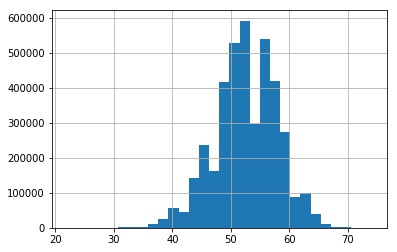

In [4]:
costs['cost'].hist(bins=30)

In [5]:
X = costs.iloc[:,:-1].values.copy()
y = costs['cost'].values.copy()

In [6]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(categories='auto')
X = one_hot_encoder.fit_transform(X).toarray();

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = map(
    lambda x: torch.tensor(x, dtype=torch.float), train_test_split(X, y, test_size=0.2, random_state=42)
)

In [8]:
from torch.utils.data import Dataset

class CostsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
from torch.utils.data import DataLoader

train_dataset = CostsDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=256)
valid_dataset = CostsDataset(X_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=256)

In [10]:
class Net(torch.nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(D_in, H1)
        self.fc2 = torch.nn.Linear(H1, H2)
        self.fc3 = torch.nn.Linear(H2, D_out)
        
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x
    

model = Net(256, 512, 128, 1)
loss_fn = torch.nn.MSELoss(reduction='mean')

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    for x_batch, y_batch in train_dataloader:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    model.eval()
    test_loss = sum(loss_fn(model(x_batch), y_batch) for x_batch, y_batch in valid_dataloader) / len(valid_dataloader)
    print(f"Epoch {epoch + 1}/{n_epochs}: test set loss: {test_loss}")

Epoch 1/20: test set loss: 29.009275436401367
Epoch 2/20: test set loss: 28.643714904785156
Epoch 3/20: test set loss: 28.792444229125977


KeyboardInterrupt: 